---
title: "Density-Based Spatial Clustering of Applications with Noise (DBSCAN)"
description: "A deep dive into the DBSCAN algorithm"
author: "Turbasu Chatterjee"
date: "11/14/2023"
toc: true
categories:
  - class-project
  - machine-learning
  - clustering
---



The DBSCAN algorithm, developed by Martin Ester, Hans-Peter Kriegel, Jorg Sander and Xiaowei Xu in 1996, is a powerful clustering algorithm that identifies clusters of varying shapes and sizes within data. DBSCAN can discover clusters based on the density of data points, making it particularly useful in scenarios where the number of clusters is unknown or when dealing with noisy data. The algorithm groups together points that are tightly packed and treats those points that are in low density regions as outliers. It also does not require the number of clusters to be told beforehand, unlike K-Means, where we have to specify the number of centroids. DBSCAN is one of the most commonly used and cited clustering algorithms.

At the heart of DBSCAN lies two key parameters: $\varepsilon$ which defines the radius of the search and ```minPoints```, the minimum number of points required for the algorithm to deem it a cluster.

Further, we have the following core concepts that will come handy when trying to understand what the algorithm does:

- Core Points: A core point is a point in the dataset that has at least ```minPoints``` many points in the cluster.
- Border Points: These are the points that are within the $\varepsilon$-radius of a core point but do not have neighboring points to be considered core points themselves.
- Noise (or outlier) points: These are neither core points nor in the epsilon radius of any core points.
- Density-Reachability ($\varepsilon$-reachability): Two points $P$ and $Q$ are considered $\varepsilon$-reachable if $Q$ is within $\varepsilon$ distance of $P$ i.e. $\text{distance}(P,Q) \leq \varepsilon$, where the distance is the Euclidean distance.
- Density-Connectivity ($\varepsilon$-connectivity): Two points, $P$ and $Q$, are considered to be $\varepsilon$-connected if there exists a core point $C$ such that both $P$ and $Q$ are $\varepsilon$-reachable

The DBSCAN algorithm can be outlined in the pseudocode below:

```
DBSCAN(Dataset, ϵ, minPoints):
    Initialize an empty set of clusters
    For each unvisited point P in the dataset:
        If P is visited, continue to the next point
        Find all points ϵ-reachable from P
        If the number of reachable points ≥ minPoints:
            Create a new cluster
            Add P to the cluster
            For each reachable point Q:
                If Q is not visited:
                    Mark Q as visited
                    Find all points ϵ-reachable from Q
                    If the number of reachable points ≥ minPoints:
                        Add those reachable points to the cluster
        If the point P does not belong to any cluster, mark it as noise (outlier)
    Return the set of clusters and noise points
```
The key mathematical operations in the pseudocode are the distance calculation (used to determine ϵ-reachability), the count of reachable points, and the clustering process.

Let's put theory to practice and code it out!

## Implementing the DBSCAN from Scratch

In this section, we would actually put theory to practice and code the DBSCAN algorithm from scratch and see how well the algorithm performs!

In [15]:
# Necessary imports

import numpy as np

We'll start off by coding up the helper function for calculating the euclidean distance.

In [16]:
def calculate_euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

Next, we shall code up the part where we find the core points for the core functionality of the clustering algorithm.

In [17]:
def find_core_points(data, epsilon, min_points):
    core_points = set()
    for i, point in enumerate(data):
        if len([p for p in data if calculate_euclidean_distance(point, p) <= epsilon]) >= min_points:
            core_points.add(i)
    return core_points

Now we shall move on to implementing the real algorithm for clustering.

In [19]:
def dbscan(data, epsilon, min_points):
    labels = [-1] * len(data)  # Initialize all points as noise (-1)

    core_points = find_core_points(data, epsilon, min_points)
    cluster_id = 0

    for i, point in enumerate(data):
        if labels[i] != -1 or i not in core_points:
            continue

        cluster_id += 1
        stack = [i]

        while stack:
            current_point = stack.pop()
            labels[current_point] = cluster_id
            neighbors = [p for p in range(len(data)) if calculate_euclidean_distance(data[current_point], data[p]) <= epsilon]

            for neighbor in neighbors:
                if labels[neighbor] == -1:
                    labels[neighbor] = cluster_id
                    if neighbor in core_points:
                        stack.append(neighbor)

    return labels

## Comparing The Performance Of Our Algorithm To The K-Means

Now that it is done, we shall pit the DBSCAN that we coded up and compare it to the performance of the K-Means algorithm from the ```scikit-learn``` package. In order to do this, we shall load the ```Iris``` dataset from the ```scikit-learn``` package. Let's do that below:

In [20]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

Now that we have our dataset loaded and ready, we shall scale the datapoints to fit the standard normal distribution using the ```StandardScalar``` object.

In [21]:
# Scale the features for better clustering performance
X = StandardScaler().fit_transform(X)

Now we shall perform our PCA for 2D visualization

In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

Let's apply the K-Means to the dataset

In [23]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3)
kmeans_labels = kmeans.fit_predict(X)

C:\Users\turba\anaconda3\envs\quantum-experiments\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Now we shall apply our code for DBSCAN clustering of the data

In [32]:
epsilon = 0.5
min_samples = 5
dbscan_labels = np.asarray(dbscan(X, epsilon=epsilon, min_points=min_samples))

Now let's visualize the results of each!

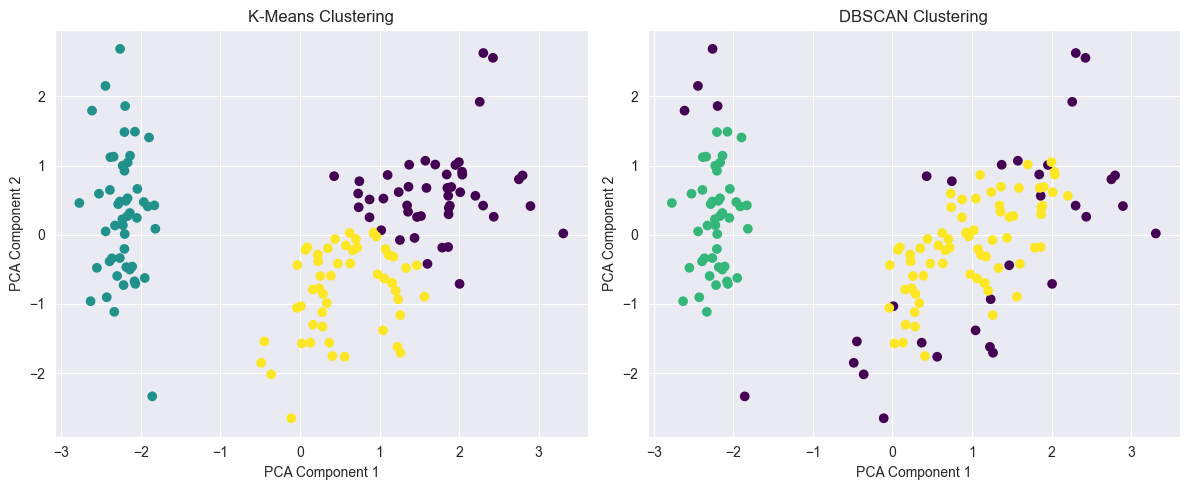

In [33]:
# Create subplots for K-Means and DBSCAN visualizations
plt.figure(figsize=(12, 5))

# K-Means Visualization
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.title('K-Means Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# DBSCAN Visualization
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.tight_layout()
plt.show()